In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import RYGate, XGate

import numpy as np

from typing import Union

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
def getWidth(bn: gum.pyAgrum.BayesNet, node: Union[str, int]) -> int:
    """
    (eq21)

    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Bayesian Network
    node: Union[str, int]
        Name or id of the corresponding node

    Returns
    -------
    int
        Number of qubits required to represent
    """
    domain_size = bn.variable(node).domainSize()
    return int(np.ceil(np.log2(domain_size)))

In [12]:
def getTotNumQBits(bn: gum.pyAgrum.BayesNet) -> int:
    """
    (eq21)

    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Baysian Network

    Returns
    -------
    int
        Total number of qubits required to build the quantum circuit
    """
    s = np.sum([getWidth(bn, id) for id in bn.nodes()], dtype=int)
    return int(s)

In [13]:
def getRootNodes(bn: gum.pyAgrum.BayesNet) -> set[int]:
    """
    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Baysian Network

    Returns
    -------
    set
        Set of int representing to root nodes id
    """
    return {id for id in bn.nodes() if len(bn.parents(id)) == 0}

In [14]:
def getAllParentSates(bn: gum.pyAgrum.BayesNet, node: Union[str, int]) -> list[dict]: #should return type [{"A":0, "B":1}, ... ] #UNIQUELY
    """
    Returns all the possible parent states of node

    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Bayesian Network
    node: Union[str, int]
        Name or id of the corresponding node


    Returns
    -------
    list[dict]
        List containting all the CPT with the node column dropped represented in a dictionnary
    """
    res = list()

    I=gum.Instantiation()
    for n in bn.cpt(node).names[1:]:
        I.add(bn.variable(n))

    I.setFirst()
    while not I.end():
        res.append(I.todict())
        I.inc()

    return res


In [16]:
def mapNodeToQBit(bn: gum.pyAgrum.BayesNet) -> dict[int: list[int]]:
    """
    Maps node from baysian network to qubits depending
    Returns a dictionary with the node id as key and a list of corresponding qubit ids as value

    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Bayesian Network

    Returns
    -------
    dict[int: list[int]]
        dict with the node id as key and a list of corresponding qubit ids as value
    """
    map = dict()
    qubit_id = 0
    for n_id in bn.nodes():
        map[n_id] = []
        for state in range(getWidth(bn, n_id)):
            map[n_id].append(qubit_id)
            qubit_id = qubit_id + 1

    return map

In [39]:
def getBinarizedProbability(binary_index: int, width: int, probability_list: list[float]) -> float:
    """
    Returns the probabilities of P = 1 in a binary context (eq17) (eq18)
    Binary_index is the index of the char in the string, depends on the width (c.f. numpy.binary_repr)

    Parameters
    ---------
    binary_index: int
        Index of char in the binary string
    width: int
        Width of the binary string
    probability_list: list[float]
        List of the probabilities from the CPT of a node in a BN

    Returns
    -------
    dict[int: list[int]]
        dict with the node id as key and a list of corresponding qubit ids as value
    """
    all_combinations = [np.binary_repr(i, width=width) for i in range(len(probability_list))]
    target_indices = [int(b_id, 2) for b_id in all_combinations if b_id[binary_index] == '1']
    where_specifier = [(i in target_indices) for i in range(len(probability_list))]

    return np.sum(probability_list, where=where_specifier)

In [167]:
def getBinarizedParameters(bn: gum.pyAgrum.BayesNet, width_dict: dict[Union[str, int]: int], param_dict: dict[Union[str, int]: int]) -> dict[str: list[int]]:
    """
    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Bayesian Network
    width_list: dict[Union[str,int]:int]
        Dict where keys are nodes and the values their corresponding width (c.f. getWidth())
    param_dict: dict[Union[str,int]:int]
        Dict where keys are nodes and the values their corresponding states

    Returns
    -------
    list[int]
        List containing the associated binarized paramters (0, 1) indexed regularly
    """
    width_dict_id = {bn.nodeId(bn.variable(key)):val for key, val in width_dict.items()}
    param_dict_id = {bn.nodeId(bn.variable(key)):val for key, val in param_dict.items()}
    bin_params_dict = dict()
    for id in param_dict_id.keys():
        #print(param_dict_id[id], width_dict_id[id])
        bin_params_dict[id] =  np.array(list(np.binary_repr(param_dict_id[id], width=width_dict_id[id]))).astype(int)
    return bin_params_dict

In [48]:
def getQuantumRegisters(bn):
    return {n_id: QuantumRegister(int(np.ceil(np.log2(bn.variable(n_id).domainSize()))), n_id) for n_id in bn.nodes()}

## Section 3.3

In [166]:
def indicatorFunction(binary_list: list[str], targets: dict[int, int]) -> list[bool]:
    """
    (eq17) (eq19)

    Parameters
    ---------
    binary_list: list[str]
        List of binary strings binary string representing basis state (mapping of V_ij to |ql...ql+m-1>)
    targets: dict[int, int]
        Dictionary containing the conditions to be satisfied

    Returns
    -------
    list[bool]
        List where True represents the string at the index satisfied the condition given by targets 
    """
    if len(targets) == 0:
        return [False] * len(binary_list)

    sorted_target_keys = sorted(list(targets))
    binary_arr = np.array([np.array(list(string)) for string in binary_list], dtype=int)[:,sorted_target_keys]
    pattern = list(map(targets.get, sorted_target_keys))

    matches = np.all(binary_arr == pattern, axis=1)

    return list(matches)


In [216]:
#not used
def getP1List(bn: gum.pyAgrum.BayesNet, node: Union[str, int], params=None) -> list[float]:
    """
    (eq18) (eq20)
    Returns a list of all the rotations to be made on the qubits representing n_id

    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Bayesian Network
    node: Union[str, int]
        Name or id of the corresponding node

    Returns
    -------
    list[float]
        List of P1 for each qubit representing the node
    """
    if params is None:
        params = dict()

    probability_list = bn.cpt(node)[params] #of BN

    width = getWidth(bn, node)

    number_of_states = bn.cpt(node).shape[0]

    binary_state_list = [np.array(list(np.binary_repr(state, width=width)), dtype=int).tolist() for state in range(number_of_states)] #list of all states in binary
    #print(binary_state_list)

    res = []

    for qb_id in range(width):
        I_qb = indicatorFunction(binary_state_list, {qb_id: 1})
        P1_qb = np.sum(probability_list, where=I_qb)
        res.append(P1_qb)

    return res

In [231]:
def getP1(bn: gum.pyAgrum.BayesNet, node: Union[str, int], qb_id: int, params: dict[int: int] = None) -> float:
    """
    (eq18) (eq20)
    Returns a list of all the rotations to be made on the qubits representing n_id

    Parameters
    ---------
    bn: gum.pyAgrum.BayesNet
        Bayesian Network
    node: Union[str, int]
        Name or id of the corresponding node

    Returns
    -------
    float
        Value of P1
    """
    if params is None:
        params = dict()

    probability_list = bn.cpt(node)[params] #of BN

    width = getWidth(bn, node)

    number_of_states = bn.cpt(node).shape[0]

    binary_state_list = [np.array(list(np.binary_repr(state, width=width)), dtype=int).tolist() for state in range(number_of_states)] #list of all states in binary
    #print(binary_state_list)

    I_qb = indicatorFunction(binary_state_list, {qb_id: 1})
    P1_qb = np.sum(probability_list, where=I_qb)

    return P1_qb

In [317]:
from qiskit.quantum_info import Operator

def multiQubitRotation(bn, node, target, params):
    """
    (Fig9) (eq18)
    """

    #print(node, target, params)

    q_reg_dict = getQuantumRegisters(bn)
    circuit = QuantumCircuit(q_reg_dict[node])

    params_qb_list = sorted(list(params))

    P1 = getP1(bn, node, target[0], params)
    if P1 == 1 :
        theta = np.pi
    else :
        theta = 2*np.arctan(np.sqrt(P1/(1-P1)))

    RY = RYGate(theta)


    if len(target) == 1: #base case
        #print(f"B --- t:{len(target)}, p:{len(params)}")

        RY = RY.control(len(params))
        circuit.append(RY, qargs=list(params_qb_list)+[target[0]])

        #print("OK B")

    elif len(params) == 0: #starting case
        #print(f"S --- t:{len(target)}, p:{len(params)}")

        circuit.append(RY, qargs=[target[0]])

        popped_qb = target.pop(0)

        U = multiQubitRotation(bn, node, target.copy(), {**params, **{popped_qb: 1}})

        circuit.append(U, qargs=target+[popped_qb])
        circuit.append(XGate(), qargs=[popped_qb])

        U = multiQubitRotation(bn, node, target.copy(), {**params, **{popped_qb: 0}})

        circuit.append(U, qargs=target+[popped_qb])
        circuit.append(XGate(), qargs=[popped_qb])

        #print("OK S")


    else: #recursion
        #print(f"R --- t:{len(target)}, p:{len(params)}")

        RY = RY.control(len(params))
        circuit.append(RY, qargs=list(params_qb_list)+[target[0]])

        popped_qb = target.pop(0)

        U = multiQubitRotation(bn, node, target.copy(), {**params, **{popped_qb: 1}})

        circuit.append(U, qargs=params_qb_list+target+[popped_qb])
        circuit.append(XGate().control(len(params)), qargs=list(params_qb_list)+[popped_qb])

        U = multiQubitRotation(bn, node, target.copy(), {**params, **{popped_qb: 0}})

        circuit.append(U, qargs=params_qb_list+target+[popped_qb])
        circuit.append(XGate().control(len(params)), qargs=list(params_qb_list)+[popped_qb])

        #print("OK R")

    gate = Operator(circuit)
    gate = gate.to_instruction()

    return gate

In [232]:
getBinarizedParameters(bn, {0:2}, {0:2})


{0: array([1, 0])}

In [234]:
getP1(bn,0,0)

0.1

In [46]:
def getTheta(bn, n_id, params=None):
    """
    Computes the rotation angle theta of multi state discrete variables (eq18)
    Returns a list of roation for each of the qubits encoding the discrete variable in binary
    Takes pyAgrum.BayesNet object, variable id, list of parent states
    """
    if params is None:
        params = dict()

    if len(bn.parents(n_id)) != len(params):
        raise NameError("params length must match number of parents")

    probability_list = bn.cpt(n_id)[params].tolist()

    theta_list = []
    width = getWidth(bn, n_id)

    print()
    for binary_index in range(width):
        P1 = getBinarizedProbability(binary_index, width, probability_list)
        print(P1)
        theta_list.append(np.pi) if P1 == 1 else theta_list.append(2*np.arctan(np.sqrt(P1/(1-P1))))

    return theta_list

In [94]:
getBinarizedParameters(bn, {0:2}, {0:0})

{0: array([0, 0])}

In [49]:
def buildCircuit(bn):
    """
    Build quantum cicuit representation of a baysian networks
    Takes pyAgrum.BayesNet object
    Returns qiskit.QuantumCircuit object
    """

    q_reg_dict = getQuantumRegisters(bn)
    #c_reg = ClassicalRegister(getTotNumQBits(bn), "c")
    circuit = QuantumCircuit(*list(q_reg_dict.values()))

    root_nodes = getRootNodes(bn)
    internal_nodes = bn.nodes().difference(root_nodes)

    n_qb_map = mapNodeToQBit(bn)

    for n_id in root_nodes:
        theta_list = getTheta(bn, n_id)
        for qb_number in range(len(n_qb_map[n_id])): #qubit number is NOT qubit id, for implementational constaint reasons with list getThetaDiscrete
            rotation = RYGate(theta_list[qb_number])
            circuit.append(rotation, [n_qb_map[n_id][qb_number]])

    for n_id in internal_nodes:

        parent_id_set = bn.parents(n_id)
        parent_qbit_list = np.ravel([n_qb_map[p_id] for p_id in parent_id_set]) #list containing qubit id of each of the parents in order

        for params_dict in getAllParentSates(bn, n_id): #params is dict

            width_dict = {p_id:getWidth(bn, p_id) for p_id in parent_id_set}

            bin_params = getBinarizedParameters(bn, width_dict, params_dict)

            #print(bin_params)

            theta_list = getTheta(bn, n_id, params_dict)

            circuit.barrier()

            #print(list(bin_params.values()))

            for ctrl_qb_id in np.array(parent_qbit_list)[np.where(np.ravel(list(bin_params.values()))==0)]:
                circuit.append(XGate(), qargs=[ctrl_qb_id])

            for qb_number in range(len(n_qb_map[n_id])):
                rotation = RYGate(theta_list[qb_number]).control(len(parent_qbit_list))
                circuit.append(rotation, qargs=list(parent_qbit_list)+[n_qb_map[n_id][qb_number]])

            for ctrl_qb_id in np.array(parent_qbit_list)[np.where(np.ravel(list(bin_params.values()))==0)]:
                circuit.append(XGate(), qargs=[ctrl_qb_id])

    circuit.barrier()

    #for n_id in bn.nodes():
    #    for qb_id in n_qb_map[n_id]:
    #        print(qb_id)
    #        circuit.measure(qb_id, 0)

    circuit.measure_all()

    return circuit

In [319]:
g = multiQubitRotation(bn3, 0, [0,1,2], {})
g


0.008434855312832668
0.4501620322124369
0.3751277002910235
0.3751277002910235
0.4501620322124369
0.3751277002910235
0.3751277002910235


Instruction(name='unitary', num_qubits=3, num_clbits=0, params=[array([[ 0.99577364+0.j, -0.09184147+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.09184147+0.j,  0.99577364+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.09925467+0.j,
        -0.00915438+0.j,  0.        +0.j,  0.        +0.j,
        -0.99081464+0.j,  0.09138409+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.00915438+0.j,
         0.09925467+0.j,  0.        +0.j,  0.        +0.j,
        -0.09138409+0.j, -0.99081464+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.99577364+0.j, -0.09184147+0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.09184147+0.j,  0.99577364+0.j,
         0.  

In [50]:
bn = gum.fastBN("A[3,5]->C{chaud|tiede|froid}<-B;C->D", 3)

id_B = bn.idFromName("B")
id_C = bn.idFromName("C")

bn.cpt("A").fillWith([0.2, 0.7, 0.1])
bn.cpt(id_B)[:] = [0.3, 0.6, 0.1]
bn.cpt(id_C)[0, 0] = [0.15, 0.80, 0.05]
bn.cpt(id_C)[0, 1] = [0.3, 0.6, 0.1]
bn.cpt(id_C)[1, 0] = [0.4, 0.5, 0.1]
bn.cpt(id_C)[1, 1] = [0.1, 0.8, 0.1]

print(bn)
print(bn.variable("C"))

BN{nodes: 4, arcs: 3, domainSize: 81, dim: 28, mem: 336o}
C:Labelized({chaud|tiede|froid})


In [259]:
bn3 = gum.fastBN("A->C<-B",5)

bn3.cpt("C")

(pyAgrum.Potential<double>@0x5b989edeba10) 
             ||  C                                              |
A     |B     ||0        |1        |2        |3        |4        |
------|------||---------|---------|---------|---------|---------|
0     |0     || 0.3374  | 0.1387  | 0.1632  | 0.1799  | 0.1808  |
1     |0     || 0.3869  | 0.0440  | 0.1964  | 0.0527  | 0.3200  |
2     |0     || 0.1541  | 0.3488  | 0.1790  | 0.1507  | 0.1675  |
3     |0     || 0.0209  | 0.2710  | 0.1792  | 0.3617  | 0.1672  |
4     |0     || 0.2198  | 0.2525  | 0.1325  | 0.2607  | 0.1345  |
0     |1     || 0.1766  | 0.0860  | 0.4654  | 0.0452  | 0.2268  |
[...13 more line(s) ...]
4     |3     || 0.1926  | 0.0421  | 0.3917  | 0.0442  | 0.3293  |
0     |4     || 0.0168  | 0.1158  | 0.4354  | 0.0315  | 0.4004  |
1     |4     || 0.0803  | 0.0071  | 0.4928  | 0.4150  | 0.0047  |
2     |4     || 0.2716  | 0.1126  | 0.2056  | 0.3062  | 0.1039  |
3     |4     || 0.0382  | 0.1594  | 0.1334  | 0.4111  | 0.2579  |
4     |4     || 0.1768  | 0.3299  | 0.0980  | 0.1457  | 0.2496  |


0.1
0.7

0.1
0.6

0.05
0.8

0.1
0.6

0.1971917852833078
0.42912523174532446

0.1
0.5

0.1
0.8

0.374255656013974
0.29164354043795243

0.32291833004048065
0.28859787930021136

0.41242966354159943
0.07353879967143367

0.11288433078551338
0.4218186598598157

0.004816206844244935
0.20867280805053434

0.029563044868482075
0.5884130421906693

0.2623722826415725
0.41862410648048


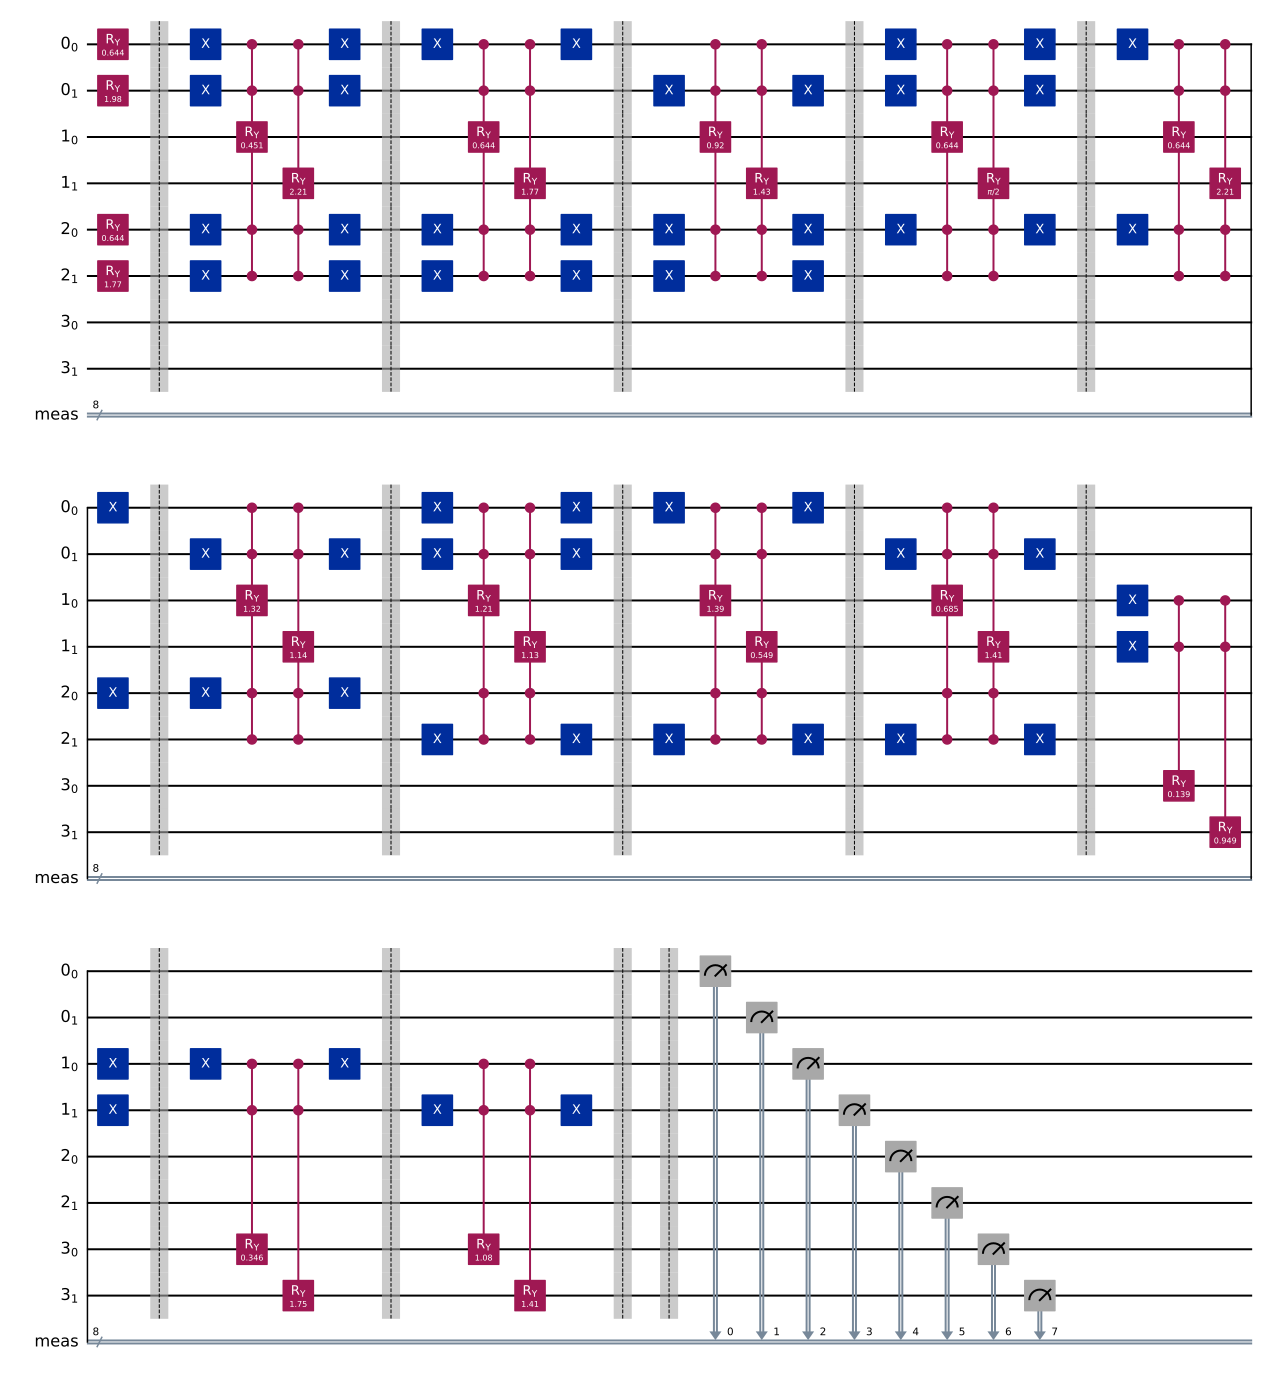

In [51]:
qbn = buildCircuit(bn)
qbn.draw(output="mpl")